## Summary

The goal of the experiment is to predict institutions' scores with linear regression on the given data from Kaggle.  

After discrete string feature values and filling in missing data, we run 4 linear regression models (OLS, Elastic, Lasso, Ridge). All four models do not carry out results with high R-Square and low RMSE(MSE).

Further data processing is tested: 
1. VIF select features
2. Lasso select features
3. Feature expansions
4. Remove outlying observations   

Among which feature expansion(3) performs best with an expansion degree set to 3;
The evaluation scores reach to under this expanded data model:  
MSE is: 4.823456482920338  
RMSE is: 2.196236891348549  
R2 is: 0.9124179073592951   

This also suggests that the independent features and dependent features do not entirely follows a linear regression model:   
$Y$ = $X$$\beta$+ $\epsilon$  
But more like:  
$Y$ = $X^3$$\beta$+ $\epsilon$  or $Y$ = $X^4$$\beta$+ $\epsilon$  ($X$ is the dimension reduction of original $X$).

In [36]:
import numpy as np
import pandas as pd

import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import sklearn.linear_model as linear_model
from sklearn.metrics import r2_score, mean_squared_error, SCORERS
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sb
import matplotlib.pyplot as plt

RANDOM_SEED = 2020 # random seed from sample code

In [37]:
data_frame = pd.read_csv('./cwurData.csv')

In [38]:
data_frame = data_frame.drop(columns=["institution"])

In [39]:
def visual_true_predict(x_test, y_test, y_predict):
    x_range = range(len(x_test))
    plt.plot(x_range, y_test,label = 'test_score')
    plt.plot(x_range, y_predict, color='r',label ='prediction_score')

In [40]:
def evaluate_prediction(y_predict, y_test):
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.power(mse, 0.5)
    r2 = r2_score(y_test, y_predict)
    print("MSE is: {}".format(mse))
    print("RMSE is: {}".format(rmse))
    print("R2 is: {}".format(r2))

## 1. Data Analyze

### 1-1. Discrete Region Category

In [41]:
# ref: https://www.geeksforgeeks.org/how-to-convert-categorical-string-data-into-numeric-in-python/
# todo: what is the theory and math behind this???
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data_frame["region"])
data_frame.drop(columns="region", inplace=True)
data_frame["region"] = labels
data_frame

world_rank  national_rank  quality_of_education  alumni_employment  \
0              1              1                     7                  9   
1              2              2                     9                 17   
2              3              3                    17                 11   
3              4              1                    10                 24   
4              5              4                     2                 29   
...          ...            ...                   ...                ...   
2195         996              7                   367                567   
2196         997              4                   236                566   
2197         998             18                   367                549   
2198         999             40                   367                567   
2199        1000             83                   367                567   

      quality_of_faculty  publications  influence  citations  broad_impact  \
0                      1             1          1          1           NaN   
1                      3            12          4          4           NaN   
2                      5             4          2          2           NaN   
3                      4            16         16         11           NaN   
4                      7            37         22         22           NaN   
...                  ...           ...        ...        ...           ...   
2195                 218           926        845        812         969.0   
2196                 218           997        908        645         981.0   
2197                 218           830        823        812         975.0   
2198                 218           886        974        812         975.0   
2199                 218           861        991        812         981.0   

      patents   score  year  region  
0           5  100.00  2012      54  
1           1   91.67  2012      54  
2          15   89.50  2012      54  
3          50   86.17  2012      57  
4          18   85.21  2012      54  
...       ...     ...   ...     ...  
2195      816   44.03  2015      37  
2196      871   44.03  2015      14  
2197      824   44.03  2015       4  
2198      651   44.02  2015      48  
2199      547   44.02  2015       8  

[2200 rows x 13 columns]

### 1-2. Missing Data
ref: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

<AxesSubplot:>

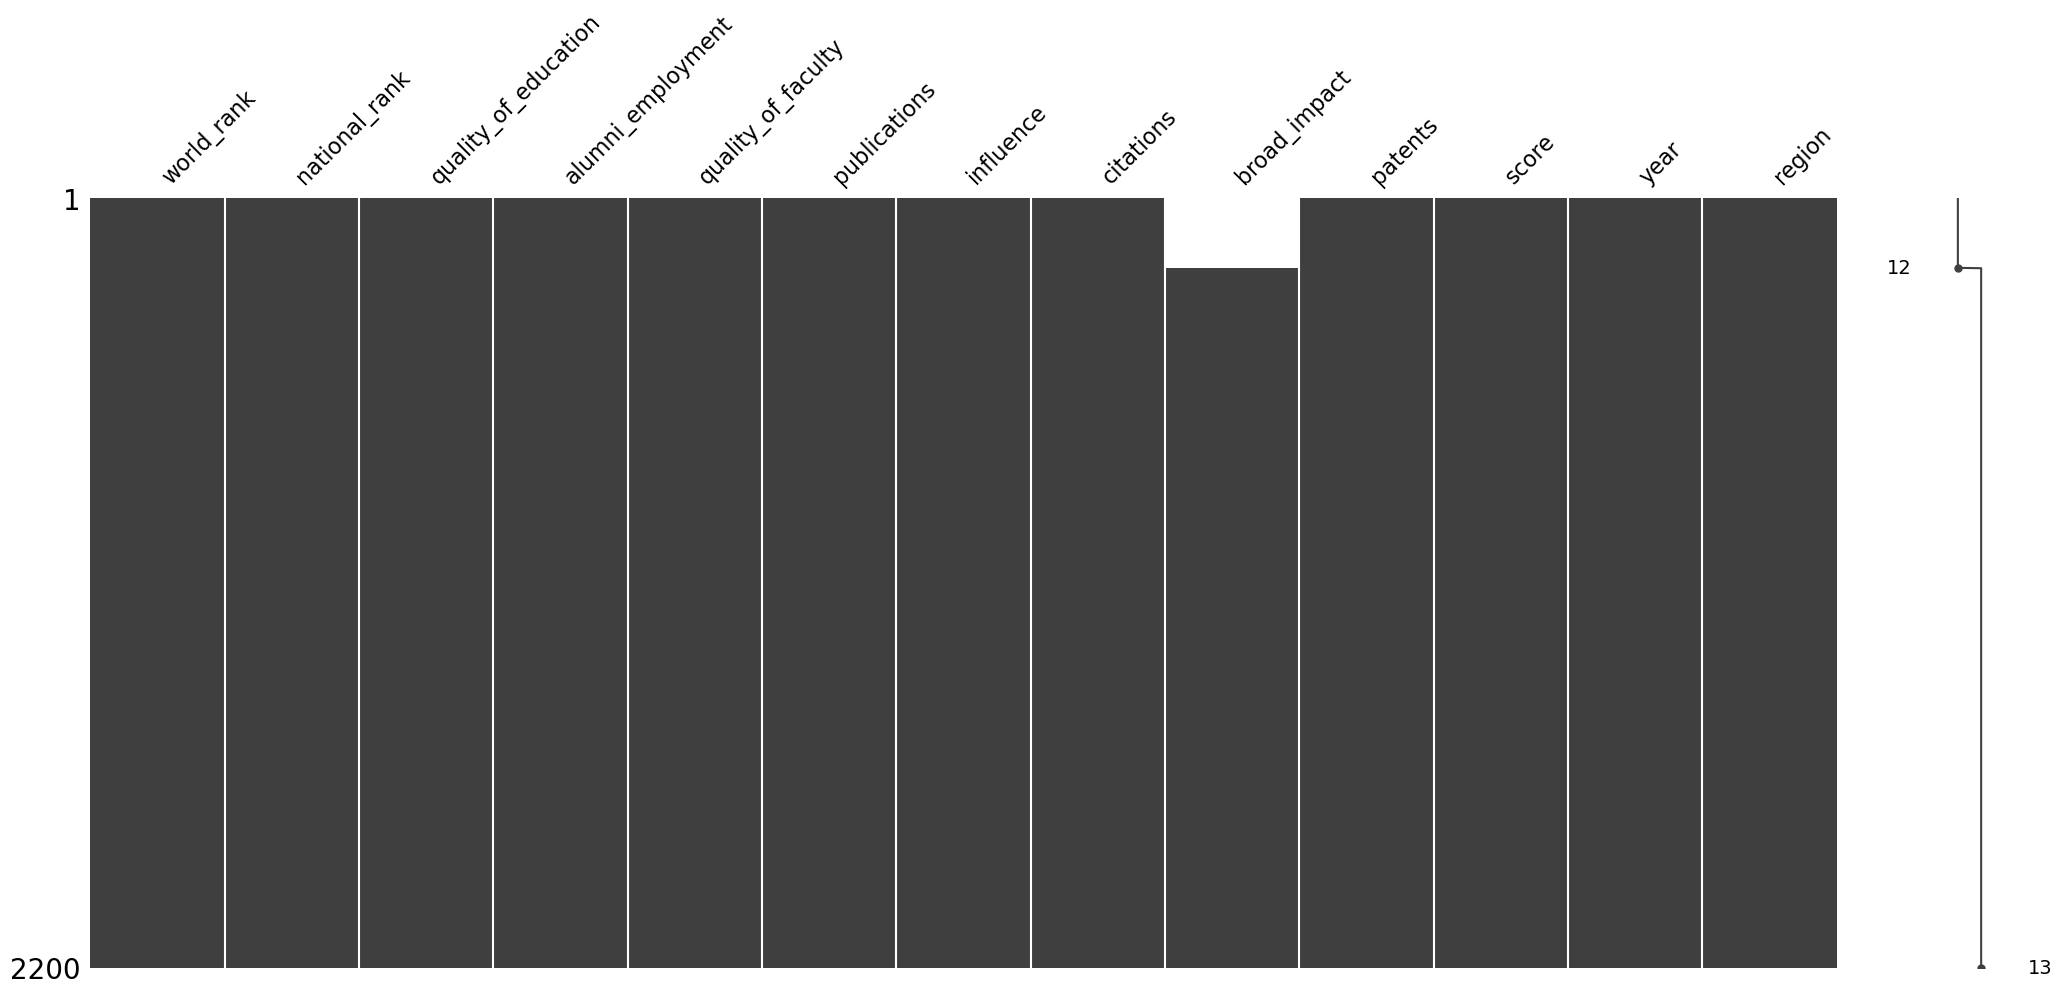

In [42]:
msno.matrix(data_frame)

#### 1-2.1 Attempt  to fill missing date with linear regression

MSE is: 4330.465763325833
RMSE is: 65.80627449814975
R2 is: 0.9480511140277353


"data_frame.loc[data_frame['broad_impact'].isnull(),['broad_impact']] = (\n    data_frame.loc[data_frame['broad_impact'].isnull(),['broad_impact']].apply(lambda x: y_fill)\n)"

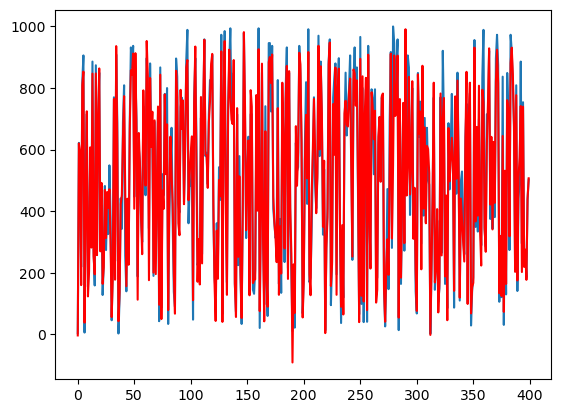

In [43]:
data_frame_to_fill = data_frame.drop(columns=["year"])
test_data = data_frame_to_fill[data_frame["broad_impact"].isnull()]

data = data_frame_to_fill.dropna()
x_for_predict = test_data.drop(columns=["broad_impact"])

x = data.drop(columns=["broad_impact"])
y = data["broad_impact"]
# split to train and validate
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

model = linear_model.Lasso(alpha=0.1)
model.fit(x_train, y_train)
y_fill = model.predict(x_validate)

visual_true_predict(x_validate, y_validate, y_fill)
evaluate_prediction(y_fill, y_validate)

"""data_frame.loc[data_frame['broad_impact'].isnull(),['broad_impact']] = (
    data_frame.loc[data_frame['broad_impact'].isnull(),['broad_impact']].apply(lambda x: y_fill)
)"""

<AxesSubplot:>

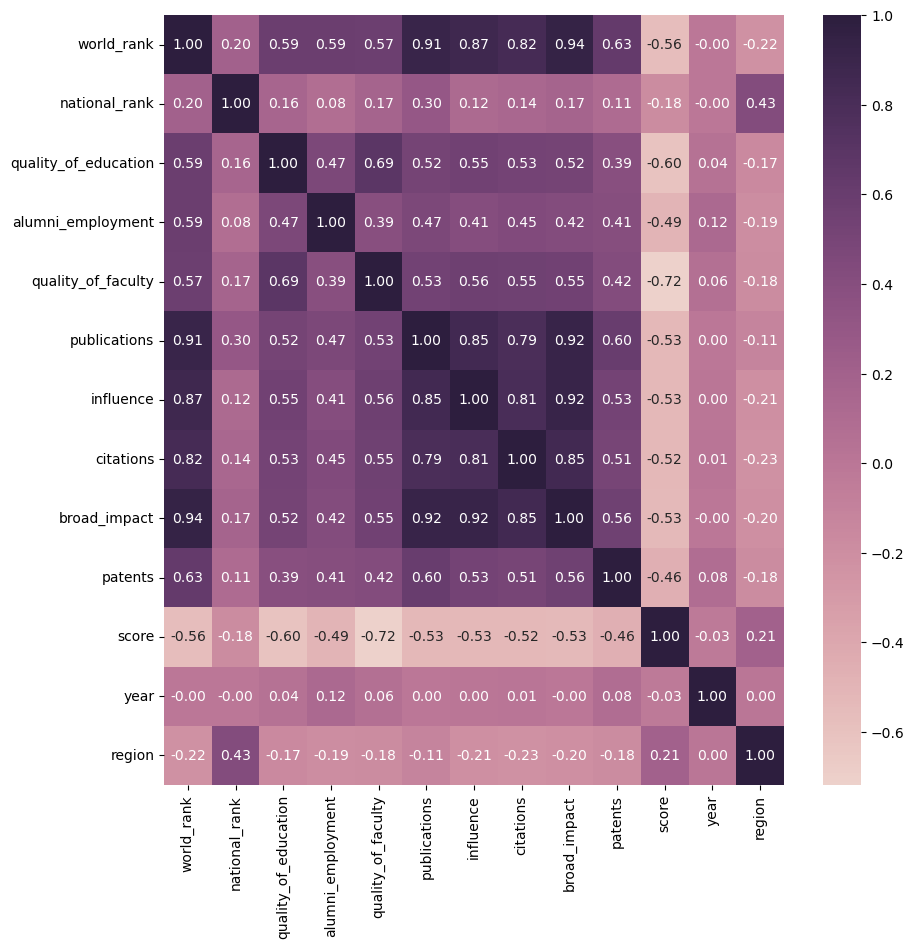

In [44]:
check_corr_data = data_frame.dropna()
correlation_matrix = check_corr_data.corr()
plt.figure(figsize = (10,10))
sb.heatmap(correlation_matrix, cmap=sb.cubehelix_palette(as_cmap=True), annot=True, fmt=".2f")

#### 1-2-2. Fill Missing Data with Neighboring Mean
From the above result, we can see that linear regression is not the go-to solution.  
collinearity exists among most of the features.  

From the correlation matrix above, we can see that the broad_impact has strong connection with influence.  
Leaving the rank out cos it feels more like a dependent variable.  
So, we will sort the data frame by the influence.  

In [45]:
data_frame = data_frame.sort_values(by="influence", ascending=True)
data_frame

world_rank  national_rank  quality_of_education  alumni_employment  \
0              1              1                     7                  9   
100            1              1                     1                  1   
200            1              1                     1                  1   
1200           1              1                     1                  1   
202            3              3                     3                 11   
...          ...            ...                   ...                ...   
2152         953             69                   367                567   
2064         865             13                   367                567   
2122         923             15                   367                515   
2183         984             79                   367                567   
2199        1000             83                   367                567   

      quality_of_faculty  publications  influence  citations  broad_impact  \
0                      1             1          1          1           NaN   
100                    1             1          1          1           NaN   
200                    1             1          1          1           1.0   
1200                   1             1          1          1           1.0   
202                    2            15          2          2           2.0   
...                  ...           ...        ...        ...           ...   
2152                 218           970        991        645         906.0   
2064                 218           796        991        645         809.0   
2122                 218           849        991        428         886.0   
2183                 218           858        991        812         958.0   
2199                 218           861        991        812         981.0   

      patents   score  year  region  
0           5  100.00  2012      54  
100         7  100.00  2013      54  
200         2  100.00  2014      54  
1200        3  100.00  2015      54  
202         1   98.69  2014      54  
...       ...     ...   ...     ...  
2152      839   44.07  2015       8  
2064      871   44.17  2015      51  
2122      735   44.11  2015      23  
2183      672   44.04  2015       8  
2199      547   44.02  2015       8  

[2200 rows x 13 columns]

In [46]:
# extract the feature column with nan values
broad_impact_array = np.array(data_frame["broad_impact"])
# get indices and values for non-nans
values = [(i, val) for i, val in enumerate(broad_impact_array) if not np.isnan(val)]
indices, values = zip(*values)
# use np.interp to fill in missing data
result = np.interp(np.arange(len(broad_impact_array)), indices, values)

data_frame = data_frame.drop(columns=["broad_impact"])
data_frame["broad_impact"] = result
data_frame

world_rank  national_rank  quality_of_education  alumni_employment  \
0              1              1                     7                  9   
100            1              1                     1                  1   
200            1              1                     1                  1   
1200           1              1                     1                  1   
202            3              3                     3                 11   
...          ...            ...                   ...                ...   
2152         953             69                   367                567   
2064         865             13                   367                567   
2122         923             15                   367                515   
2183         984             79                   367                567   
2199        1000             83                   367                567   

      quality_of_faculty  publications  influence  citations  patents   score  \
0                      1             1          1          1        5  100.00   
100                    1             1          1          1        7  100.00   
200                    1             1          1          1        2  100.00   
1200                   1             1          1          1        3  100.00   
202                    2            15          2          2        1   98.69   
...                  ...           ...        ...        ...      ...     ...   
2152                 218           970        991        645      839   44.07   
2064                 218           796        991        645      871   44.17   
2122                 218           849        991        428      735   44.11   
2183                 218           858        991        812      672   44.04   
2199                 218           861        991        812      547   44.02   

      year  region  broad_impact  
0     2012      54           1.0  
100   2013      54           1.0  
200   2014      54           1.0  
1200  2015      54           1.0  
202   2014      54           2.0  
...    ...     ...           ...  
2152  2015       8         906.0  
2064  2015      51         809.0  
2122  2015      23         886.0  
2183  2015       8         958.0  
2199  2015       8         981.0  

[2200 rows x 13 columns]

### 1-3. Shuffling Data

The original data follows the rank by year. Shuffling data can help feed data to the train model in a more random manner.

In [47]:
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

## 2. Prepare Train Set and Test Set

In [48]:
data_frame.drop(columns=["world_rank", "national_rank", "year"], inplace=True)
X = data_frame.drop(columns=["score"])
Y = data_frame["score"]
X

quality_of_education  alumni_employment  quality_of_faculty  \
0                      287                253                 158   
1                      367                567                 218   
2                      367                567                 218   
3                       32                 19                  31   
4                      355                478                 210   
...                    ...                ...                 ...   
2195                   303                368                 210   
2196                   309                460                 210   
2197                   101                101                  90   
2198                   206                567                 179   
2199                   367                529                 218   

      publications  influence  citations  patents  region  broad_impact  
0              612        554        493      552      57    256.000000  
1              616        340        645      809      57    549.000000  
2              796        991        645      871      51    809.000000  
3                8         19         23        3      28     21.666667  
4              278        255        363      426      18    311.000000  
...            ...        ...        ...      ...     ...           ...  
2195           992        669        800      637      54    869.000000  
2196            77        110         87      426       6     64.000000  
2197            60         57         49      101      54     32.000000  
2198           349        211        146      500      57    313.000000  
2199           892        863        812      516      25    969.000000  

[2200 rows x 9 columns]

In [49]:
# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1760, 9), (440, 9), (1760,), (440,))

## 3. Test Sklearn Linear Models

### 3-1. Basic Linear Regression

In [50]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00371068 -0.00571028 -0.06140435  0.00021886  0.00217317  0.00122862
 -0.00129909  0.02265755 -0.00456167]
intersection is 62.10365732732225
MSE is: 26.679139206931755
RMSE is: 5.165185302284106
R2 is: 0.5155725256629521


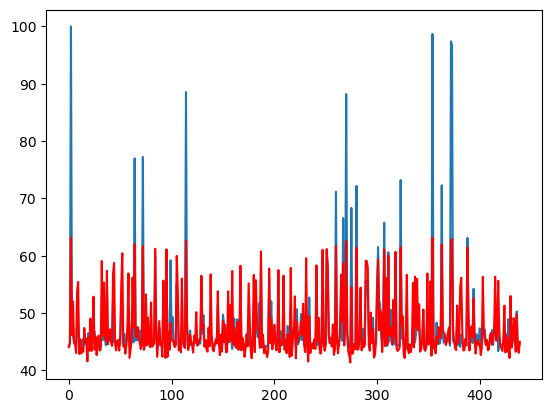

In [51]:
visual_true_predict(x_test, y_test, y_predict)

Use basic linear regression (Ordinary Least Squares) to describe y is not ideal.
The plot also suggests that higher scores has low prediction accuracy.

### 3-2. Elastic Net CV

In [52]:
model = linear_model.ElasticNetCV(cv=5, random_state=0)
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00374545 -0.00571406 -0.06075349  0.00018089  0.00194559  0.00100818
 -0.00132754  0.01894217 -0.00424911]
intersection is 62.208306351627684
MSE is: 26.690702636794505
RMSE is: 5.166304543558626
R2 is: 0.5153625622499785


### 3-3. Ridge Regression

In [53]:
model = linear_model.Ridge(alpha=0.5)
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00371069 -0.00571028 -0.06140434  0.00021886  0.00217317  0.00122862
 -0.0012991   0.02265753 -0.00456167]
intersection is 62.10365748273661
MSE is: 26.679139218083517
RMSE is: 5.165185303363619
R2 is: 0.5155725254604635


### 3-4. Lasso

In [54]:
model = linear_model.Lasso(alpha=0.1)
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00371095 -0.00571018 -0.06135755  0.00021249  0.00215318  0.00121127
 -0.00130073  0.02236885 -0.00453235]
intersection is 62.11182046784977
MSE is: 26.67967277065193
RMSE is: 5.165236952033462
R2 is: 0.51556283745962


### Summary
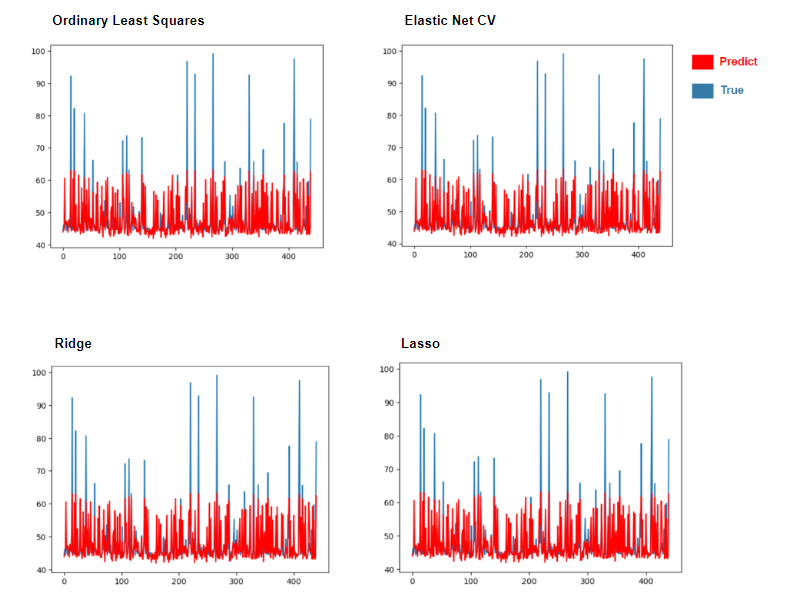

Here are the graphs to visualize the true score(blue) and prediction score(red).  
After dropping feature "year"(irrelevant), ranks(depend on score), we run train and test with 4 linear models from sklearn.  

By comparing the graphs and R2, RMSE, MSE, it came to notice that different algorithms do not carry out results with obvious differences.  
And for all four models, large errors occur when predicting scores that are comparatively higher.  

Also, as mentioned in 1-1, high correlation exists among "independent" variables.  
Thus, we need to modify the data model for collinearity situations.

## 4. Data Modification under collinearity

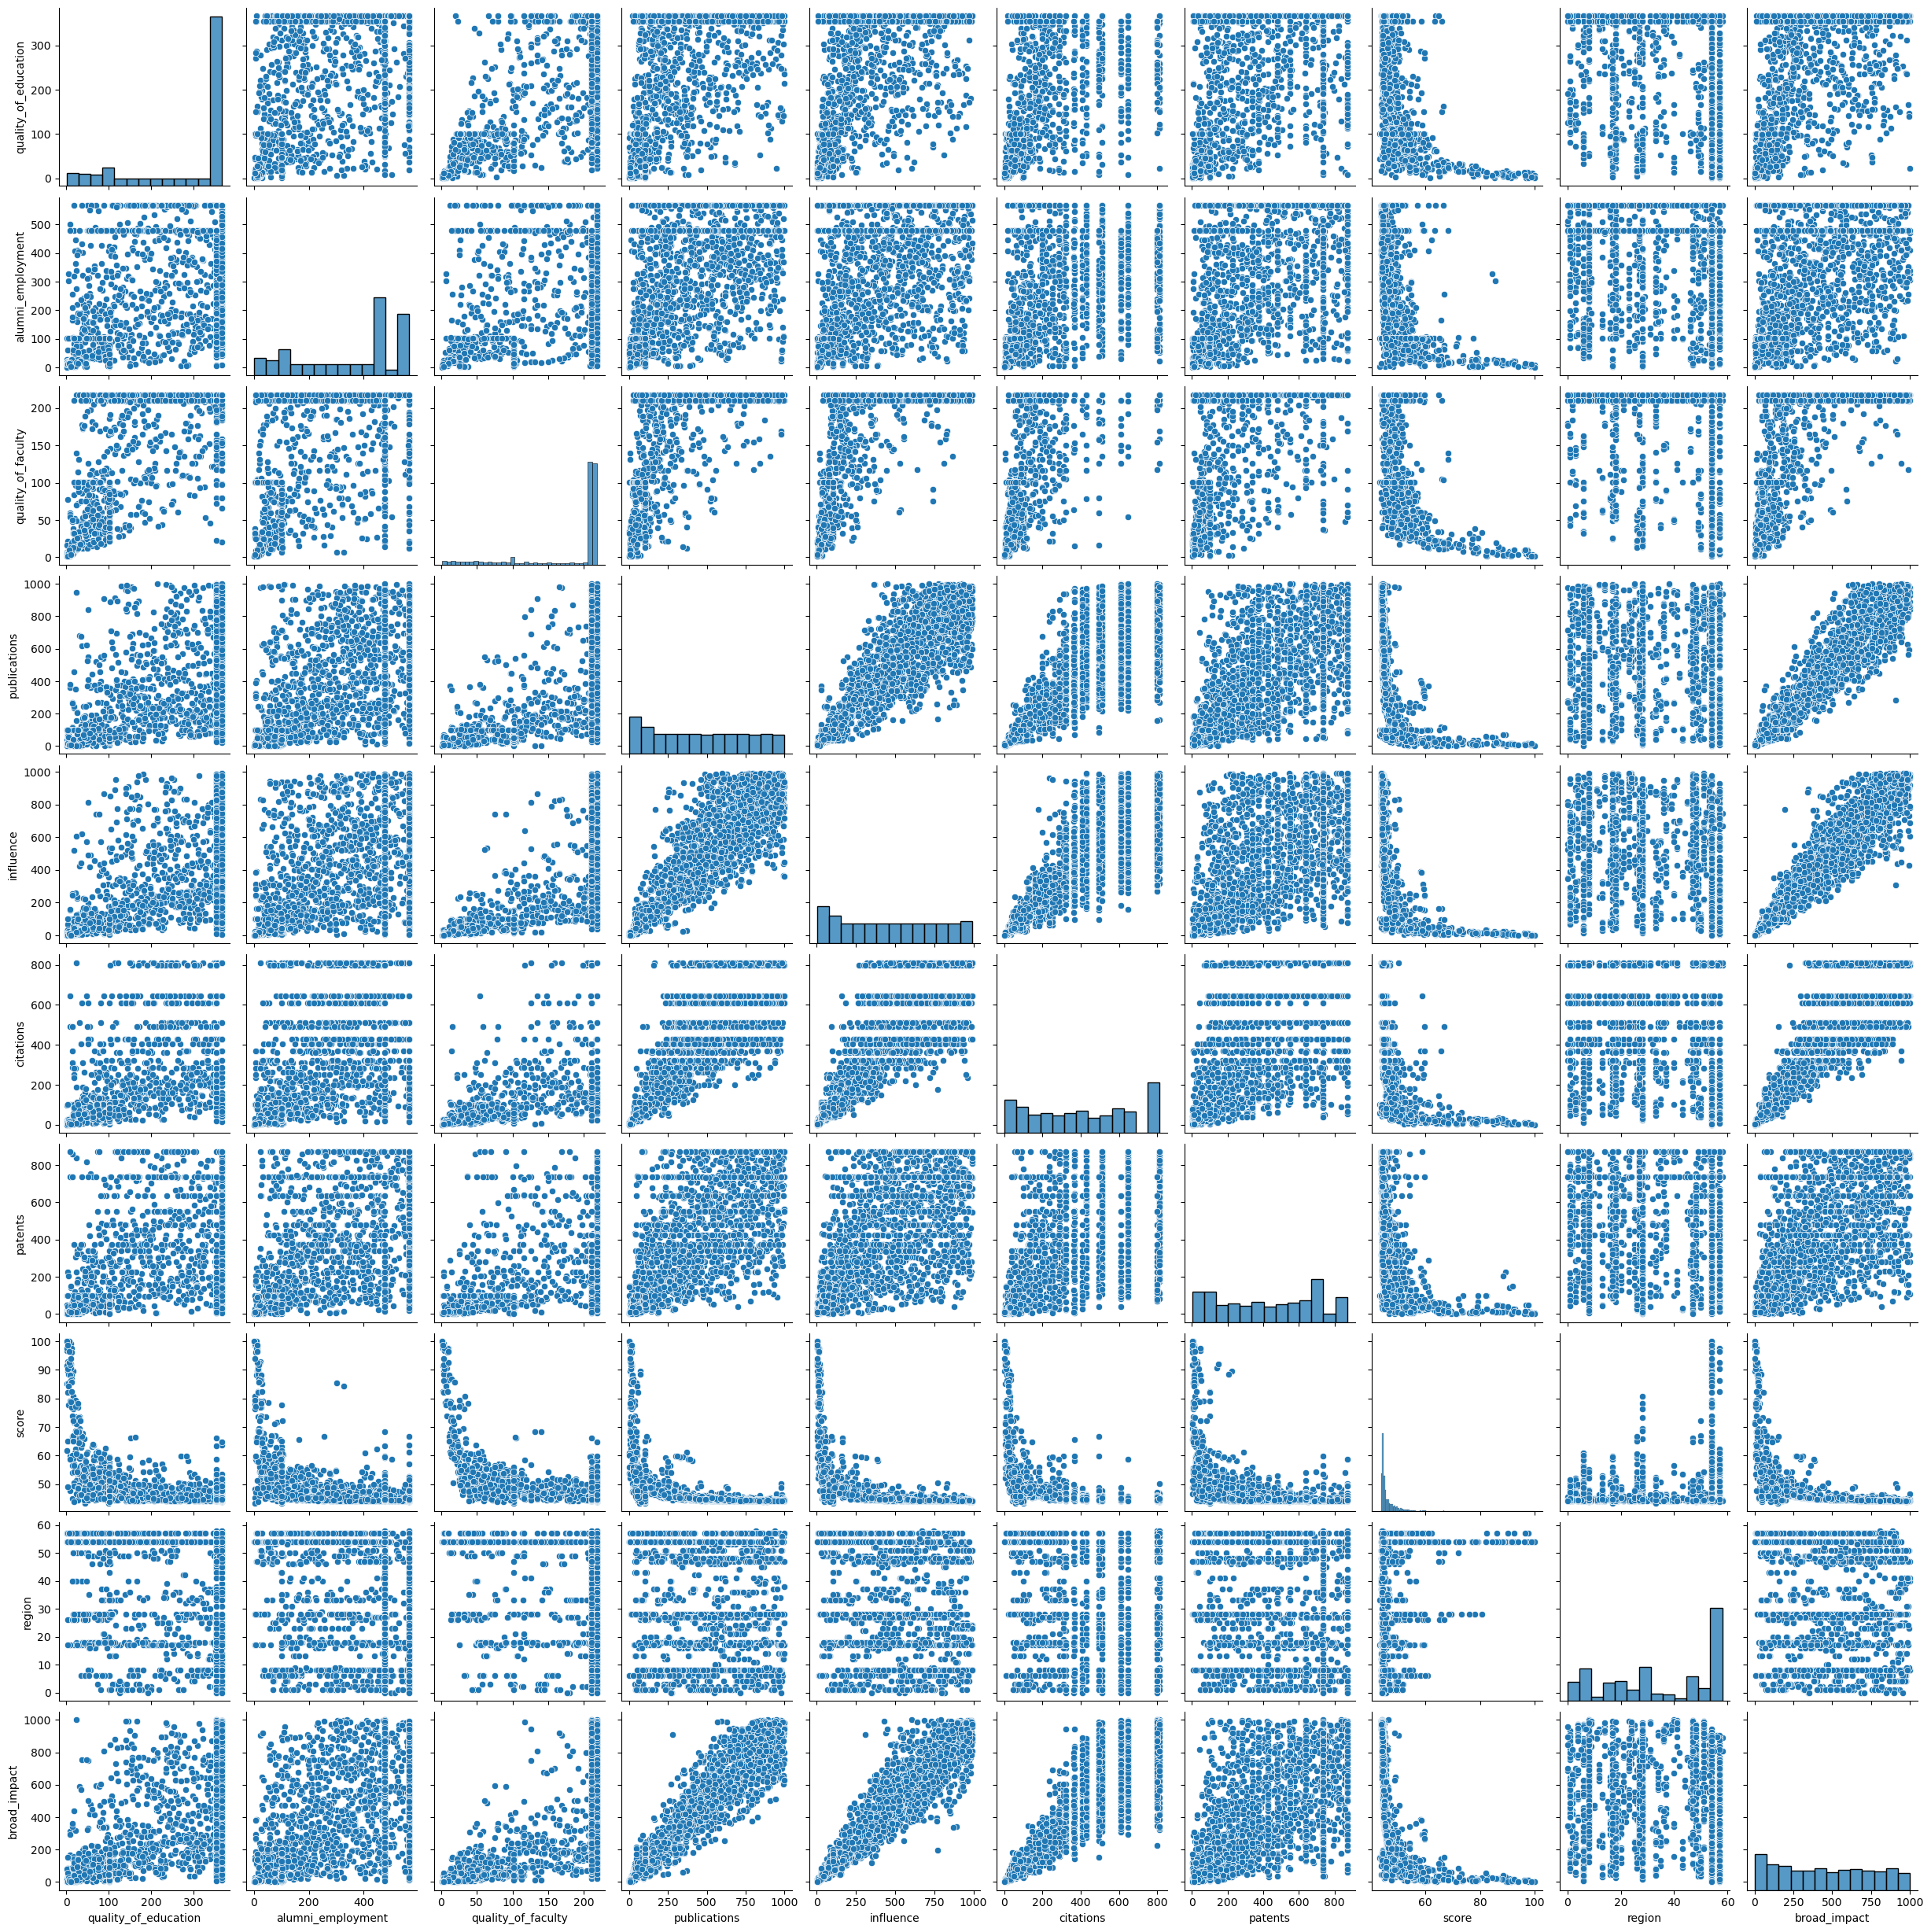

In [110]:
sb.pairplot(data_frame)

ref: https://kyrcha.info/2019/03/22/on-collinearity-and-feature-selection  

Intercorrelation or multi-collinearity is the existence of predictor variables that are (highly) correlated among themselves.   For example publications, influence, citations are correlated among themselves. More publications mean more citations and influence, and vice-versa.

### 4-1. Analyze Colinearity

ref: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/  

Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent.   
The goal of regression is to isolate the relationship between each independent variable and the dependent variable.  
If independent variable $X1$ is highly-correlated to another independent variable $X2$, one could not say dependent variable $Y$ is affected by $X1$ and $X2$.  
As for regression, the ideal situation is that you can change the value of one independent variable and not the others.  

Multicolinearity may result in:  
1. coefficients become very sensitive to small changes in the model;  
2. reduces the precision of the estimated coefficients.  

**Variance Inflation Factors** is a common way to test multilinearity.

In [55]:
feature_data = data_frame.drop(columns=["score"])
vif_data = pd.DataFrame()

vif_data["variables"] = feature_data.columns
vif_data["VIF"] = [variance_inflation_factor(feature_data.values, i) for i in range(feature_data.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)

vif_data

variables        VIF
8          broad_impact  50.355761
3          publications  28.249336
4             influence  26.491687
2    quality_of_faculty  21.943460
0  quality_of_education  18.782893
5             citations  16.719382
1     alumni_employment   8.403664
6               patents   6.951912
7                region   2.741915

Test to remove independent variables with high-VIF;
Here we use the mean value of VIF to determin which ones to drop.

In [56]:
feature_data = feature_data.drop(columns=["broad_impact", "publications", "influence"])

x_train, x_test, y_train, y_test = train_test_split(feature_data, Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00356271 -0.00565136 -0.06162862 -0.00078753 -0.00170325  0.02204895]
intersection is 62.12134299216151
MSE is: 26.780735545365115
RMSE is: 5.175010680700583
R2 is: 0.5137277863238217


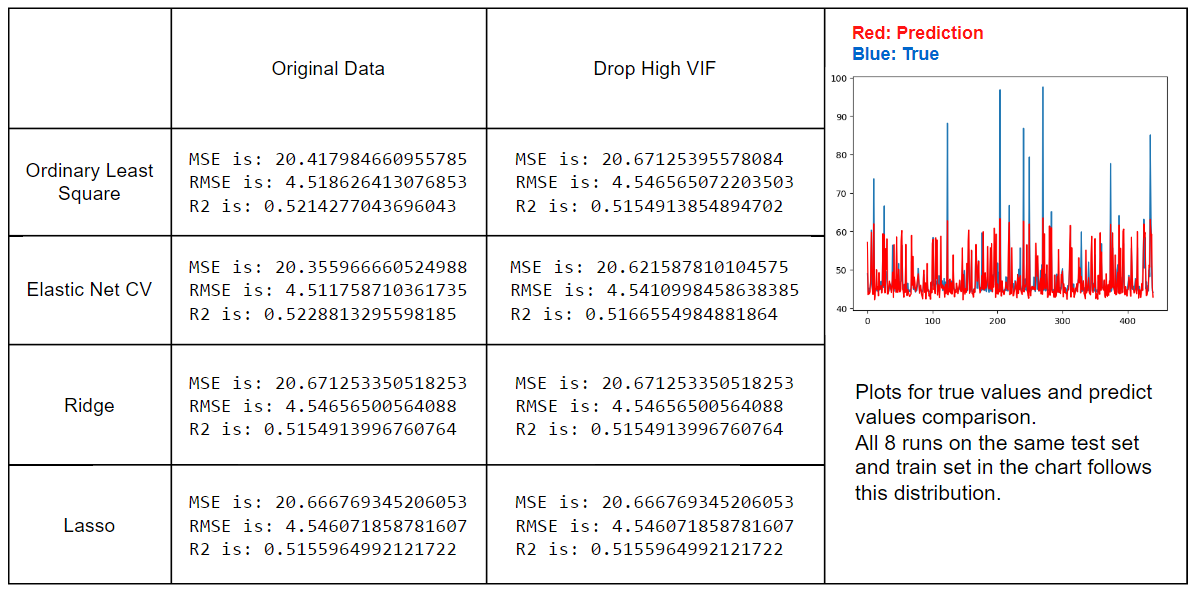
Dropping independent variables does not result in obvious improvement in the four linear regression models.  
Regression and prediction on high scores are still in low accuracy.  

In the following steps, we will try:
1. Other ways to fix multicollinearity
2. Observing data again and see if there are other factors affecting the learning

### 4-2. Lasso Select Features

ref: https://blog.csdn.net/lys_828/article/details/104669997?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-104669997-blog-104846106.235%5Ev38%5Epc_relevant_anti_t3_base&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-104669997-blog-104846106.235%5Ev38%5Epc_relevant_anti_t3_base&utm_relevant_index=5

In [57]:
# use Lasso to extract features
feature_data = data_frame.drop(columns=["score"])
feature_names = feature_data.columns
y = Y

lasso_model = linear_model.Lasso(alpha = 10)
select_model = SelectFromModel(lasso_model)

select_model.fit(feature_data,y)
select_features = feature_names[select_model.get_support()]

In [58]:
feature_data = data_frame[select_features]

x_train, x_test, y_train, y_test = train_test_split(feature_data, Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

coefficent is: [-0.00361749 -0.00576229 -0.06157365  0.00215509 -0.00136716 -0.00368283]
intersection is 63.150020126922
MSE is: 26.932962401564403
RMSE is: 5.189697717744686
R2 is: 0.5109637214526533


### 4-3. Feature Expansion

In [59]:
feature_data = data_frame.drop(columns=["score"])
print(feature_data.shape[1])
polynomy = PolynomialFeatures(degree=3)

new_feature_data = polynomy.fit_transform(feature_data)
print(new_feature_data.shape[1])

9
220


coefficent is: [ 1.17490155e-09 -1.71825656e-01 -1.05673762e-01 -4.73570683e-01
 -3.98176312e-02  1.04807025e-01 -2.15478633e-02 -3.42631182e-03
 -6.39545838e-03 -9.98797643e-02  7.09692947e-04  5.65867217e-06
  8.30897394e-04 -1.56221198e-04 -6.42916736e-05 -2.26450046e-04
 -5.55441610e-05 -6.92069392e-04  3.34255015e-04  3.10406623e-04
  3.39413866e-04 -7.10369168e-05 -1.74340899e-04 -4.52187096e-05
 -2.82367972e-05 -3.38813078e-04  2.55835321e-04  3.18449991e-03
  3.67374458e-04 -6.73810529e-04  1.79660744e-04 -9.18142036e-05
 -2.35491547e-04  1.43718907e-04  1.80044387e-04 -4.98629149e-05
 -2.66818945e-04  1.69781697e-05  2.03436746e-04  1.00138858e-04
  6.10309897e-06  3.90282388e-05  7.16532653e-05 -7.15229765e-04
 -4.17875798e-05  5.72865859e-05 -7.36630798e-06  1.06649718e-04
  3.25677326e-04  6.77193513e-05 -1.58617460e-04 -8.05767255e-05
  2.79619766e-03  3.78652382e-04 -2.25023316e-04 -8.93791114e-07
  4.40377843e-08 -9.70816334e-07 -9.58180504e-08  2.77727353e-07
  3.150455

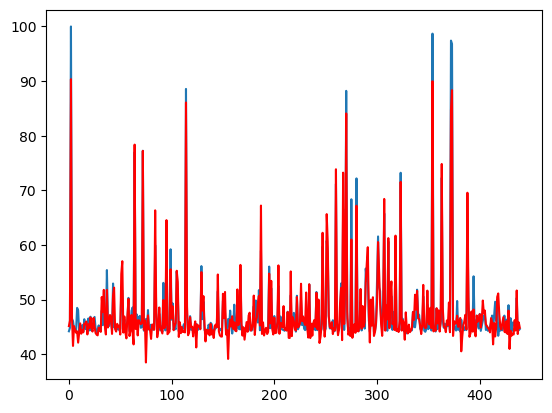

In [60]:
x_train, x_test, y_train, y_test = train_test_split(new_feature_data, Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

visual_true_predict(x_test, y_test, y_predict)

Here test on different degree to expand features on the basic linear regression model.  
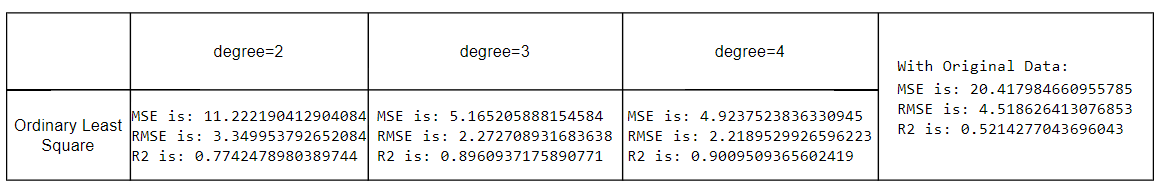  

We can see by doing feature expansion, the regression model gets better on explain the dependent variable.  
When degree=4, R2 is quite high (close to 1).  

However, it is consuming to run other models e.g. Elastic Net CV, as the iteration increases exponentially.  

It is still difficult to predict on higher scores(above 70).  Prediction on lower scores also starts getting unstable.  

A guess is that there exists outlying observations in samples.


### 4-4. Outlying Observations (on Original Data)

ref: https://www.scielo.br/j/bcg/a/kPytvJQWxC5ZNjm987zmnVy/?lang=en  
ref: https://book.itheima.net/course/221/1270308811000782849/1271373716516773889  

A common way of testing outlying observations is $3σ-rule$.  
Code example: https://blog.csdn.net/baidu_38963740/article/details/117547331

In [61]:
def three_sigma(feature):
    """return indices for elements that not fall in the 3σ range"""
    rule = (np.mean(feature)-3*feature.std()>feature) | (np.mean(feature)+3*feature.std()<feature)
    index = np.arange(feature.shape[0])[rule]
    return index

def out_three_sigma(data):
    to_del_indices = set()
    new_data = data.copy()
    for col in data.columns:
        del_indices = three_sigma(data[col])
        to_del_indices.update(del_indices)
    new_data = new_data.drop(new_data.index[i] for i in to_del_indices)
    return new_data 

In [62]:
new_data_frame = out_three_sigma(data_frame)
new_data_frame

quality_of_education  alumni_employment  quality_of_faculty  \
0                      287                253                 158   
1                      367                567                 218   
2                      367                567                 218   
3                       32                 19                  31   
4                      355                478                 210   
...                    ...                ...                 ...   
2195                   303                368                 210   
2196                   309                460                 210   
2197                   101                101                  90   
2198                   206                567                 179   
2199                   367                529                 218   

      publications  influence  citations  patents  score  region  broad_impact  
0              612        554        493      552  46.21      57    256.000000  
1              616        340        645      809  44.46      57    549.000000  
2              796        991        645      871  44.17      51    809.000000  
3                8         19         23        3  69.49      28     21.666667  
4              278        255        363      426  45.79      18    311.000000  
...            ...        ...        ...      ...    ...     ...           ...  
2195           992        669        800      637  44.46      54    869.000000  
2196            77        110         87      426  49.79       6     64.000000  
2197            60         57         49      101  46.39      54     32.000000  
2198           349        211        146      500  45.58      57    313.000000  
2199           892        863        812      516  44.05      25    969.000000  

[2138 rows x 10 columns]

coefficent is: [-0.00207439 -0.00325199 -0.02464927 -0.00051101  0.00010443 -0.00051853
 -0.00136676  0.00569147 -0.00273777]
intersection is 55.11473214704368
MSE is: 7.065122764115983
RMSE is: 2.658029865166301
R2 is: 0.5638392863034344


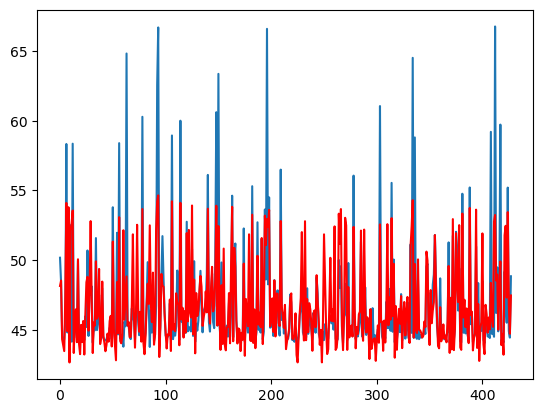

In [63]:
feature_data = new_data_frame.drop(columns=["score"])
new_Y = new_data_frame["score"]

x_train, x_test, y_train, y_test = train_test_split(feature_data, new_Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

visual_true_predict(x_test, y_test, y_predict)

It is an interesting fact that by dropping the outliers, without any extra process on data, the regression result got improved massively.  
However, this means that in the model train, high/low scores are excluded. This can also be observed by comparing this grpah and with the graph in Section 4-3.  
Thus, we will choose expansion for data processing. The regression result here can give us a better understanding on how independent variables affect the target.

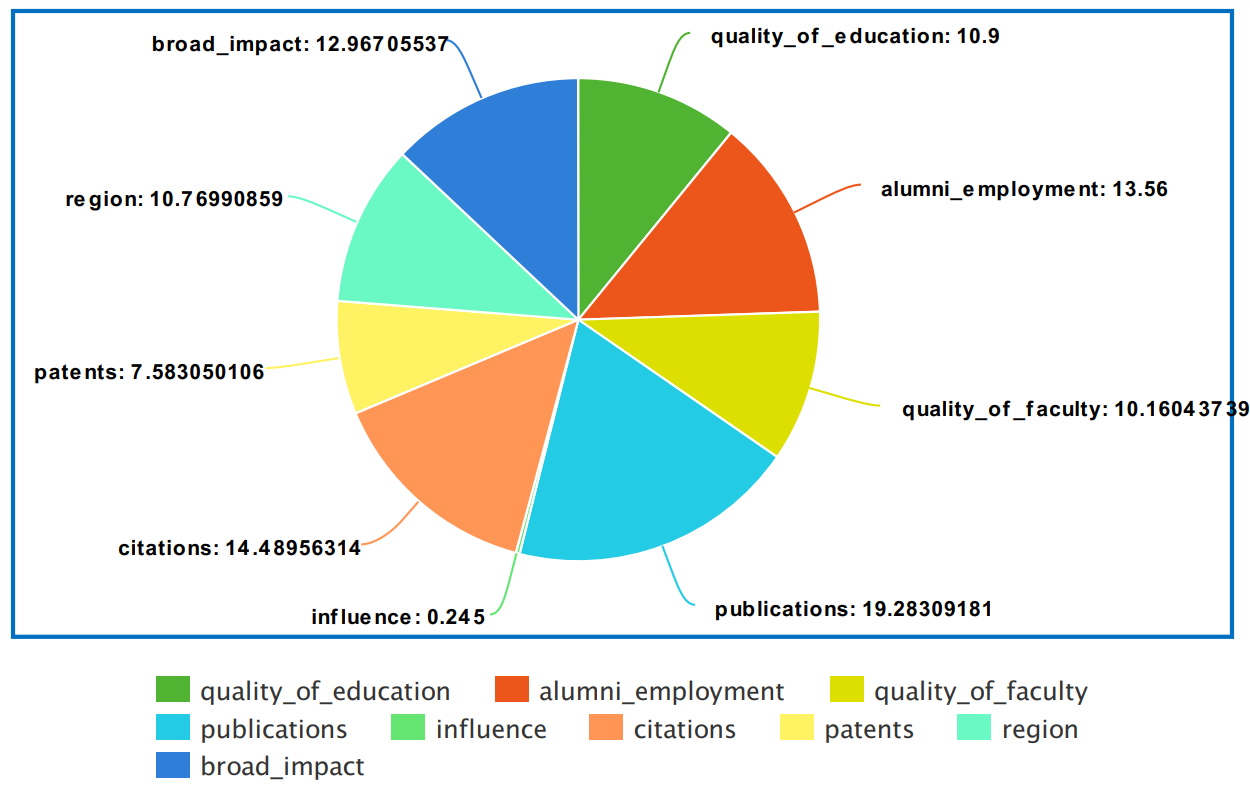

## 5. Cross Validation on Regression with Different Exspansion Degree

By comparing tests run in Section 3 and 4,   
we recognize the feature expansion carries out the best regression result.

In this section, we will analyze results on different expansion degree with cross validation.


In [64]:
model = linear_model.LinearRegression()

mean_r2 = []
mean_mse = []
mean_rmse = []

for degree_v in [1, 2, 3, 4, 5]:
    # feature expansion
    feature_data = data_frame.drop(columns=["score"])
    polynomy = PolynomialFeatures(degree=degree_v)
    new_feature_data = polynomy.fit_transform(feature_data)
    Y = data_frame["score"]
    # cross validation
    r2_scores = cross_val_score(model, new_feature_data, Y, cv=5, scoring ='r2')
    mse_scores = np.abs(cross_val_score(model, new_feature_data, Y, cv=5, scoring ='neg_mean_squared_error'))
    mse = np.mean(mse_scores)
    
    mean_r2.append(np.mean(r2_scores))
    mean_mse.append(mse)
    mean_rmse.append(np.power(mse, 0.5))
    
print(mean_r2)
print(mean_mse)
print(mean_rmse)
    

[0.4913159288905523, 0.740049431835255, 0.8929607787951632, 0.8276287137540344, -36074502.022863284]
[29.614198364567677, 14.793975266940597, 6.1217734617237, 9.838646034021565, 2117207102.2942882]
[5.441892902710203, 3.8462937052363277, 2.4742217891134377, 3.1366616065526682, 46013.11880642615]


In [65]:
def draw_graph(y, y_label, y_lim):
    degree = [1, 2, 3, 4, 5]
    plt.ylim(y_lim[0],y_lim[1])

    plt.xticks(degree)  
    plt.plot(degree, y, marker='o', label=y_label)
    plt.legend()

    plt.xlabel('Feature Expansion Degree')
    plt.ylabel(y_label)
    plt.title(y_label)

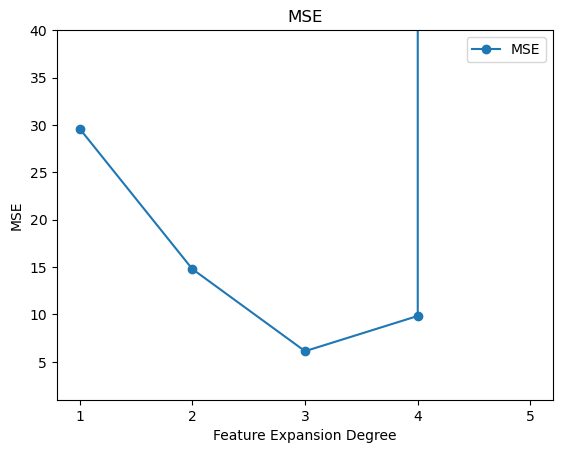

In [66]:
draw_graph(mean_mse, "MSE", (1, 40))

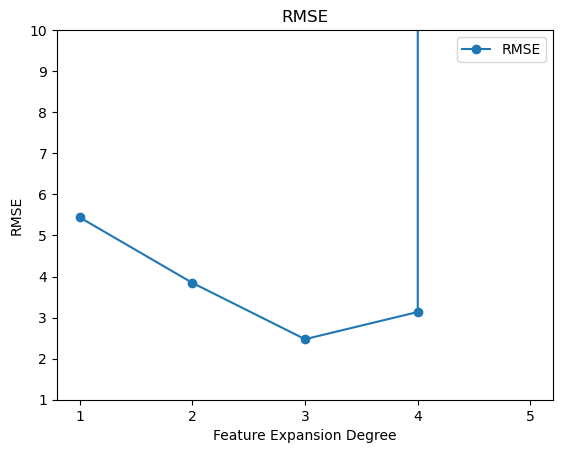

In [67]:
draw_graph(mean_rmse, "RMSE", (1,10))

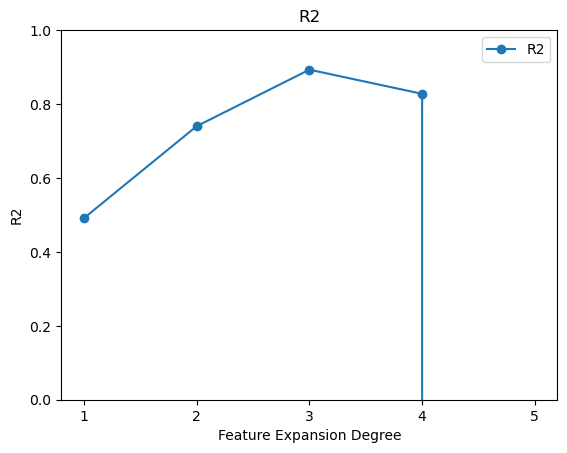

In [68]:
draw_graph(mean_r2, "R2", (0, 1))

Mean squared error (MSE) measures the amount of error in statistical models.   
R-squared(R2) measures how well the trained model fits the data.  

In short, the greater the MSE and RMSE is, the weaker the model is to predict dependent variables.  
The greater the R2 is, the better the model explains the changes in the dependent variable by independent variables.  

When the feature expansion degree grows from 1 -3, the trained model gradually gets better on performance.  
After the degree gets greater than 3, the model prediction has a sharp decline, especially when the degree gets to 5.

This suggests that the independent features and dependent features do not entirely follows a linear regression model:   
$Y$ = $X$$\beta$+ $\epsilon$  
But more like:  
$Y$ = $X^3$$\beta$+ $\epsilon$  or $Y$ = $X^4$$\beta$+ $\epsilon$



## 6. Dimension Deduction vs Feature Expansion

Based on the conclusion above, in this section, we compare the regression performance between dimension deduction(np.cbrt()) and feature expansion.

coefficent is: [ 1.17490155e-09 -1.71825656e-01 -1.05673762e-01 -4.73570683e-01
 -3.98176312e-02  1.04807025e-01 -2.15478633e-02 -3.42631182e-03
 -6.39545838e-03 -9.98797643e-02  7.09692947e-04  5.65867217e-06
  8.30897394e-04 -1.56221198e-04 -6.42916736e-05 -2.26450046e-04
 -5.55441610e-05 -6.92069392e-04  3.34255015e-04  3.10406623e-04
  3.39413866e-04 -7.10369168e-05 -1.74340899e-04 -4.52187096e-05
 -2.82367972e-05 -3.38813078e-04  2.55835321e-04  3.18449991e-03
  3.67374458e-04 -6.73810529e-04  1.79660744e-04 -9.18142036e-05
 -2.35491547e-04  1.43718907e-04  1.80044387e-04 -4.98629149e-05
 -2.66818945e-04  1.69781697e-05  2.03436746e-04  1.00138858e-04
  6.10309897e-06  3.90282388e-05  7.16532653e-05 -7.15229765e-04
 -4.17875798e-05  5.72865859e-05 -7.36630798e-06  1.06649718e-04
  3.25677326e-04  6.77193513e-05 -1.58617460e-04 -8.05767255e-05
  2.79619766e-03  3.78652382e-04 -2.25023316e-04 -8.93791114e-07
  4.40377843e-08 -9.70816334e-07 -9.58180504e-08  2.77727353e-07
  3.150455

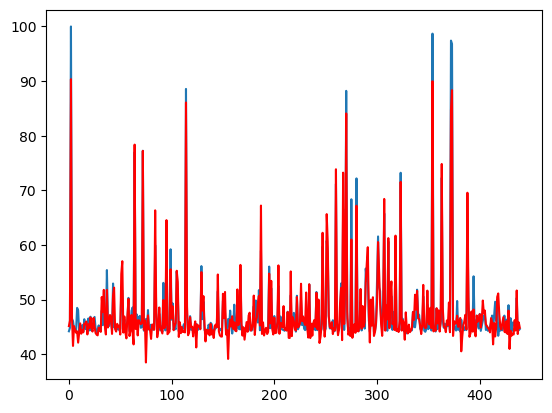

In [69]:
feature_data = data_frame.drop(columns=["score"])
polynomy = PolynomialFeatures(degree=3)
new_feature_data = polynomy.fit_transform(feature_data)

x_train, x_test, y_train, y_test = train_test_split(new_feature_data, Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

visual_true_predict(x_test, y_test, y_predict)

coefficent is: [-1.89412883e+04 -3.38908128e+04 -1.05108820e+05  1.65469796e+04
  2.07695264e+04  1.07377506e+04 -7.23559332e+03 -8.18638281e-01
 -6.02865705e+04]
intersection is 177504.7803741306
MSE is: 10.77136439385596
RMSE is: 3.2819756845314925
R2 is: 0.8044185455907091


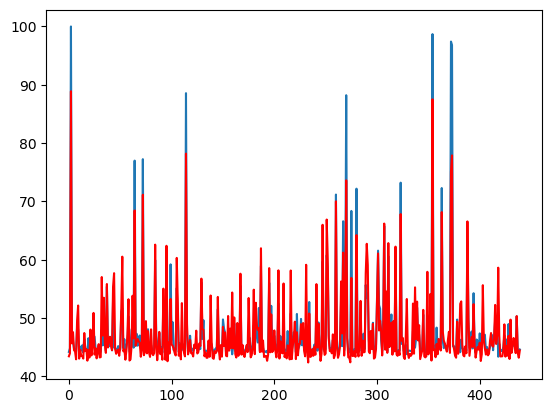

In [70]:
feature_data = np.power(data_frame.drop(columns=["score"]), 1/19683)  # 9 features both in 3 degree; 19683 = 3^9

x_train, x_test, y_train, y_test = train_test_split(feature_data, Y, test_size=0.2, random_state=RANDOM_SEED)

# test on 4 linear models used in Section 3; here use basic linear regression as an example.
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
print("coefficent is: {}".format(model.coef_))
print("intersection is {}".format(model.intercept_))

y_predict = model.predict(x_test)
evaluate_prediction(y_predict, y_test)

visual_true_predict(x_test, y_test, y_predict)

In general, feature expansion is the go-to-solution for a better linear regression.
Feature reduction gives promising results, but still lack of accuracy to predict high scores.


## 7 Summary

Main features that affect the dependent variable “score” are: publications, citations, alumni employment.  
Region can have a comparatively large impact on “score”. This is possibly because region values are discrete and do not have much correlation with other independent variables.  

Through this practice, we understand that a good dataset is a foundation for linear regression results.   
Ways of optimizing data, such as: VIF, outliers, feature expansion, dimension reduction et.c are tested. Among which feature expansion carries out the best regression result with low RMSE and high R-Squared (especially for explaining high scores). It is also important to choose data optimization methods based on the nature of the given dataset.  
